# Demo: Auto-encoders with simple MLP


This demo is based on this one: https://blog.keras.io/building-autoencoders-in-keras.html

We will see some auto-encoders' architectures using Multi-layers perceptron (MLP). 

In [1]:
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
from matplotlib          import colors
%matplotlib inline

In [2]:
#%load_ext tensorboard
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Sequential, Model

2023-04-26 09:13:22.776650: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 09:13:22.778010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 09:13:22.801325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 09:13:22.801693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 09:13:23.205647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## I. Presenting the API

In **tensorflow** (and **keras**), there is no API to define an auto-encoder. 
We will use dense layers (fully connected layers) and lambda layers (functions defined by users) to construct our auto-encoders.

## II. Clustering autoencoder

Here, we will present a simple traditional autoencoder. 
We load some images depicting handwritten numbers encoded as a matrix of 28X28 pixels.
Each pixel is represented by its grey level (number 0-255).
To use MLPs, we flatten each image into a vector of 784 elements.
Then, we normalize its values dividing them by 255 (MinMax normalization).

(60000, 784)


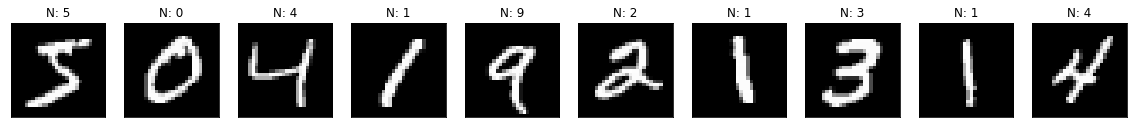

In [3]:
# Load MNIST dataset 
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flattening each image: 
# transform a matrix of 28X28 into a vector of 784
x_train = x_train.reshape([-1, 784])

print(x_train.shape)

# Normalizing the values (min-max normalization)
x_train = x_train / 255.0

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28)) # recontruct the matrix
    plt.gray()
    plt.title("N: " + str(y_train[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
# We use a dimension of 2 to plot the result
code_dim = 2 


# =====================================================
# Encoder : Input[784] X 100  X 2
# Decoder : 2 X 100 X 784
# =====================================================

# the input layer has 784 elements 
input_img = Input(shape=(x_train.shape[1],), name='AE_encoder_in')
# the first hidden layer has 100 neurones and ReLu activation
encoded = Dense(100, activation='relu', name='AE_encoder_h')(input_img)
# the second (encoding) layer has 2 neurones and linear activation
# Here, we used "linear" instead of "relu" 
# because we can notice that some samples are located in the borders x=0 or y=0
encoded = Dense(code_dim, activation='linear', name='AE_encoder_out')(encoded)

# "decoded" is the lossy reconstruction of the input
# the hidden layer contains 100 neurones
decoded = Dense(100, activation='relu', name='AE_decoder_h')(encoded)
# the output layer has the same shape as the input (784)
# we use "sigmoid" because the data is normalized : values between 0 and 1
# also, we must not use softmax since the pixels can all be 1 or 0 
# but using softmax, we force them to have a sum of 1 (255 grey level)
decoded = Dense(x_train.shape[1], activation='sigmoid', name='AE_decoder_out')(decoded)


# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded, name='AE_autoencoder')

# Show the structure and number of parameters
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_encoder_in (InputLayer)  [(None, 784)]             0         
                                                                 
 AE_encoder_h (Dense)        (None, 100)               78500     
                                                                 
 AE_encoder_out (Dense)      (None, 2)                 202       
                                                                 
 AE_decoder_h (Dense)        (None, 100)               300       
                                                                 
 AE_decoder_out (Dense)      (None, 784)               79184     
                                                                 
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


2022-05-26 19:24:38.850976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-26 19:24:38.851014: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 19:24:38.851047: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kariminf-pc): /proc/driver/nvidia/version does not exist
2022-05-26 19:24:38.877703: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# the encoder take the same input as the auto-encoder
# then, returns the result of the encoded layer
encoder = Model(input_img, encoded, name='AE_encoder')

# Show the structure
# Here, we will not train the encoder, since it will be train with the auto-enoder
# (the same layers ; just we defined a reusable module)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_encoder_in (InputLayer)  [(None, 784)]             0         
                                                                 
 AE_encoder_h (Dense)        (None, 100)               78500     
                                                                 
 AE_encoder_out (Dense)      (None, 2)                 202       
                                                                 
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [6]:
# To define the decoder, we must define its input
# which is a vector of dimension 2
encoded_input = Input(shape=(code_dim,), name='AE_decoder_in')
# Retrieve the first layer of the decoder
# which is the layer before the last one of the autoencoder
# then, we feed the input into it
decoder_layer = autoencoder.layers[-2](encoded_input)
# Retrieve the last layer and connect it to the one before it
decoder_layer = autoencoder.layers[-1](decoder_layer)

# Create the decoder model
decoder = Model(encoded_input, decoder_layer, name='AE_decoder')

# Show the structure
# Here, we will not train the decoder, since it will be train with the auto-enoder
# (the same layers ; just we defined a reusable module)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_decoder_in (InputLayer)  [(None, 2)]               0         
                                                                 
 AE_decoder_h (Dense)        (None, 100)               300       
                                                                 
 AE_decoder_out (Dense)      (None, 784)               79184     
                                                                 
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [7]:
# we force the model to treat the problem as classification
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# we can train it on a problem of regression
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.fit(x_train, x_train, epochs=100)

2022-05-26 19:25:05.244962: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/100


2022-05-26 19:25:05.609316: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0560
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0478
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0457
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0445
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0437
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0431
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0426
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0422
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0419
Epoch 10/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0416
Epoch 11/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0414
Epoch 12/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0412
E

In [8]:
# encode the samples into two dimension representation
encoded_imgs = encoder.predict(x_train)

print(encoded_imgs.shape)


2022-05-26 19:35:42.846028: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


(60000, 2)


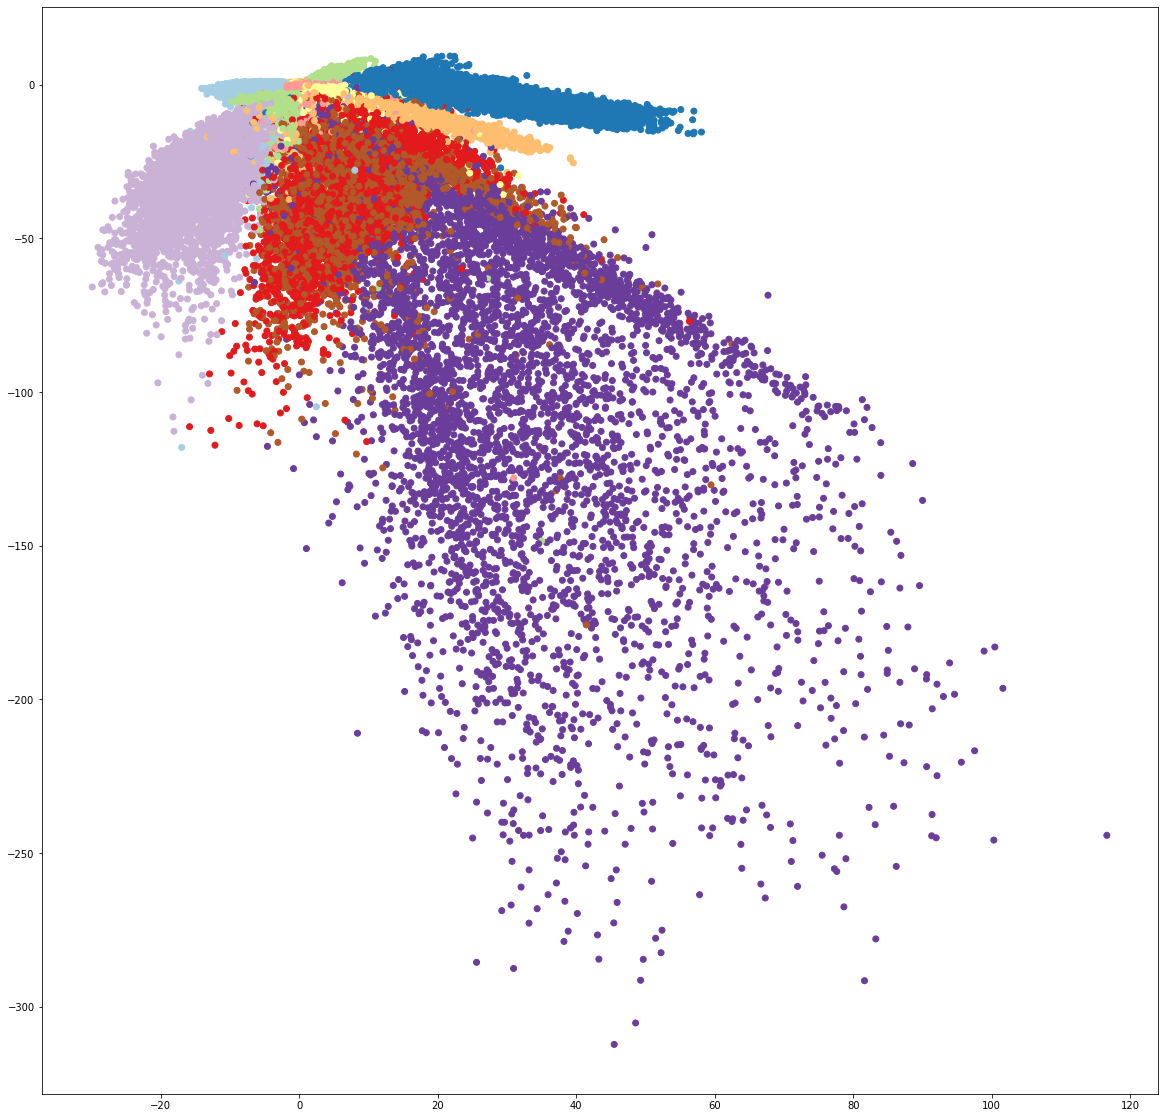

In [9]:
# plot the distribution of samples using the codes learned using the auto-encoder
# Each color represents a number
plt.figure(figsize=(20, 20))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_train, cmap = plt.cm.Paired)

In [10]:
# a function that plots some reconstructed numbers based on 
# an interval of values on x and y
# model: this is the encoder model
# nx: this is the number of values we chose over x
# ny: this is the number of values we chose over y
# interval: a tuple (min_x, min_y, max_x,max_y)
def draw_generated_images(model, nx, ny, interval):
    min_x, min_y, max_x, max_y = interval
    # generate a vector x of nx elements which the values are between min_x and max_x
    grid_x = np.linspace(min_x, max_x, nx) 
    # generate a vector y of ny elements which the values are between min_y and max_y
    grid_y = np.linspace(min_y, max_y, ny)
    
    # generate some codes by combining all values of x and y
    codes = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)
    # predict the image based on the codes 
    decoded_imgs = model.predict(codes)

    plt.figure(figsize=(20, 4))
    for xi in range(nx):
        for yi in range(ny): 
            i = yi * nx + xi
            #print(i)
            ax = plt.subplot(ny, nx, i + 1)
            plt.imshow(decoded_imgs[i].reshape(28, 28))
            plt.gray()
            #plt.title(str(codes[i]))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
print('function defined')

function defined


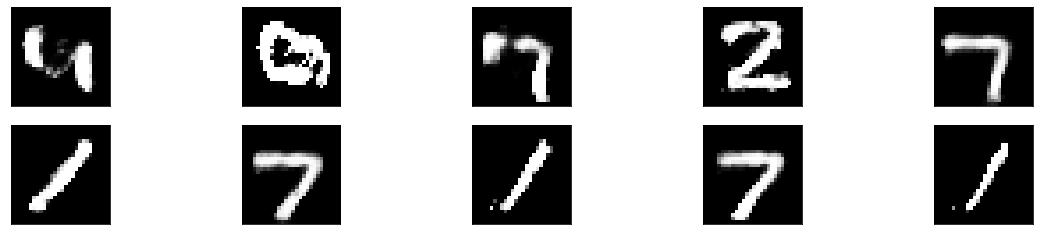

In [11]:
# plot the generated images
draw_generated_images(decoder, 5, 2, (encoded_imgs[:, 0].min(), encoded_imgs[:, 1].min(), encoded_imgs[:, 0].max(), encoded_imgs[:, 1].max()))

## III. Variational autoencoder

Here, we want to force a normal distribution of samples. 
This is why we add another loss function which is Kullback–Leibler divergence between our trained distribution and normal distribution.
We train the model to generate the mean and log sigma (to not have a negative sigma).

In [14]:
# Encoder 
# ========

# the input of the encoder has a shape of 784 elements
inputs_vae = Input(shape=(x_train.shape[1],), name='VAE_encoder_in')
# Encoder maps the image into a vector of 100 
h = Dense(100, activation='relu', name='VAE_encoder_h')(inputs_vae)
# This layer estimates the mean as a vector of two elements
z_mean = Dense(code_dim, name='VAE_encoder_mu')(h)
# This layer estimates the log sigma as a vector of two elements
z_log_sigma = Dense(code_dim, name='VAE_encoder_log_sigma')(h)

from tensorflow.keras import backend as K

# Sampling function to fuse mu and sigma
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], code_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# generating the latent variable ()
z = Lambda(sampling, name='VAE_encoder_code')([z_mean, z_log_sigma])

# Create encoder
# the output is a vector of three elements : means, log_sigmas and codes
# [ [M X 2], [M X 2], [M X 2]]
encoder_vae = Model(inputs_vae, [z_mean, z_log_sigma, z], name='VAE_encoder')

encoder_vae.summary()

Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 VAE_encoder_in (InputLayer)    [(None, 784)]        0           []                               
                                                                                                  
 VAE_encoder_h (Dense)          (None, 100)          78500       ['VAE_encoder_in[0][0]']         
                                                                                                  
 VAE_encoder_mu (Dense)         (None, 2)            202         ['VAE_encoder_h[0][0]']          
                                                                                                  
 VAE_encoder_log_sigma (Dense)  (None, 2)            202         ['VAE_encoder_h[0][0]']          
                                                                                        

In [13]:
# Decoder 
# ========

# the input of the decoder has a shape of 2 elements
latent_inputs = Input(shape=(code_dim,), name='VAE_decoder_in')
# a hidden layer of 100 elements
x = Dense(100, activation='relu', name='VAE_decoder_h')(latent_inputs)
# an output of 784 elements
outputs_vae = Dense(x_train.shape[1], activation='sigmoid', name='VAE_decoder_out')(x)

decoder_vae = Model(latent_inputs, outputs_vae, name='VAE_decoder')

decoder_vae.summary()

Model: "VAE_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_decoder_in (InputLayer)  [(None, 2)]              0         
                                                                 
 VAE_decoder_h (Dense)       (None, 100)               300       
                                                                 
 VAE_decoder_out (Dense)     (None, 784)               79184     
                                                                 
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [15]:
# instantiate VAE model
# it is constructed as an encoder on the input layer
# the third output of the encoder is passed into the decoder
outputs_vae = decoder_vae(encoder_vae(inputs_vae)[2])
vae = Model(inputs_vae, outputs_vae, name='VAE_atoencoder')

vae.summary()

Model: "VAE_atoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_encoder_in (InputLayer)  [(None, 784)]            0         
                                                                 
 VAE_encoder (Functional)    [(None, 2),               78904     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 VAE_decoder (Functional)    (None, 784)               79484     
                                                                 
Total params: 158,388
Trainable params: 158,388
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Loss function 
# =============

# Loss function between input and output

#J_loss = keras.losses.binary_crossentropy(inputs_vae, outputs_vae)
# we will use regression loss function
J_loss = keras.losses.mean_squared_error(inputs_vae, outputs_vae)

# KL divergence between our distribution and normal distribution
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 /x_train.shape[1]

# The global loss is the sum between the two
vae_loss = J_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train, x_train, epochs=100)

2022-05-26 20:16:31.754556: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-05-26 20:16:31.920824: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0589
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0505
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0492
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0483
Epoch 5/100
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0476
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0470
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0466
Epoch 8/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0462
Epoch 9/100
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0459
Epoch 10/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0456
Epoch 11/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0454
Epoch 12/100
1875/1875 [==============================] - 9s 5ms/step - l

In [17]:
# encode the samples into two dimension representation
encoded_imgs = encoder_vae.predict(x_train)[2]
print(encoded_imgs.shape)

(60000, 2)


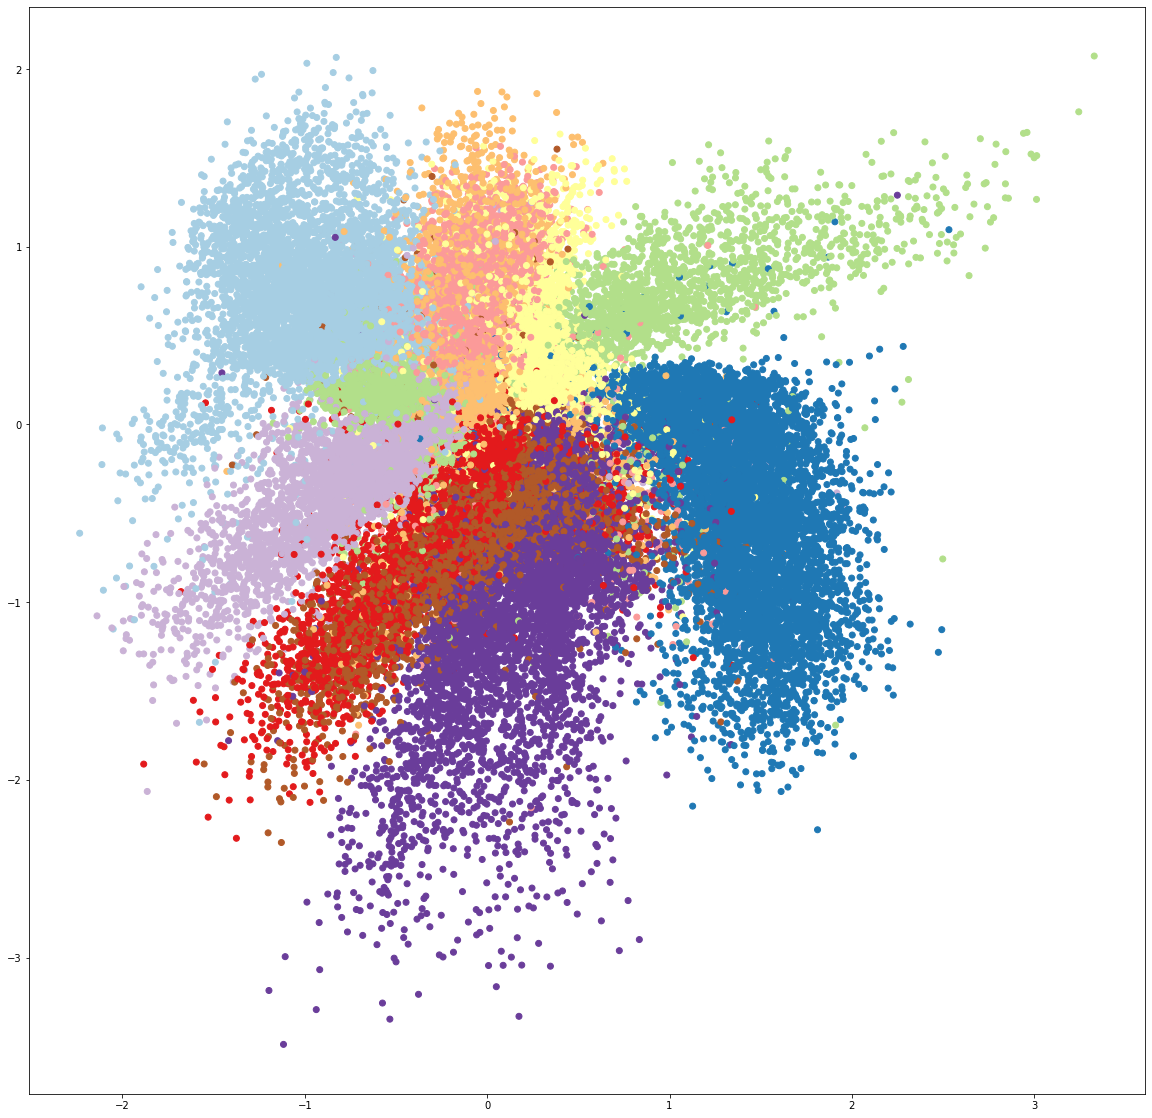

In [18]:
# plot the distribution of samples using the codes learned using the auto-encoder
# Each color represents a number
plt.figure(figsize=(20, 20))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_train, cmap = plt.cm.Paired)

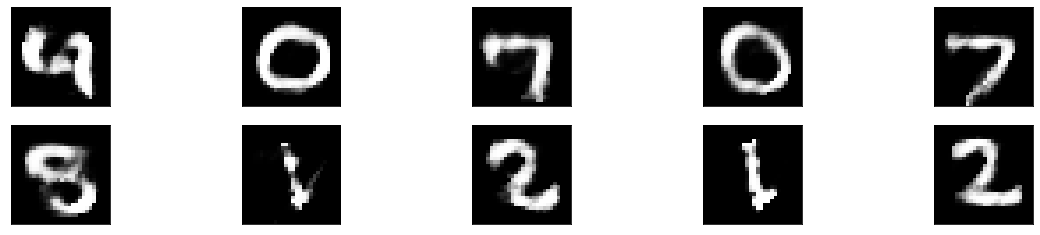

In [19]:
# plot the generated images
draw_generated_images(decoder_vae, 5, 2, (encoded_imgs[:, 0].min(), encoded_imgs[:, 1].min(), encoded_imgs[:, 0].max(), encoded_imgs[:, 1].max()))

## IV. Sparse autoencoder

Here, we want to learn a hidden representation of  the input image. 
This is why we will train the model to encode the image into a vector of the same size.

In [29]:
# Encoder 
# ========

# the input of the encoder has a shape of 784 elements
inputs_sae = Input(shape=(x_train.shape[1],), name='SAE_encoder_in')
# Encoder maps the image into a vector of the same size
# Here, we apply a sigmoid of generate a number between 0 and 1
# also, a L1 regularization to delete non essential parts of pixels
outputs_sae_encoder = Dense(x_train.shape[1], activation='sigmoid', name='SAE_encoder_out', kernel_regularizer='l1')(inputs_sae)

# Create encoder
encoder_sae = Model(inputs_sae, outputs_sae_encoder, name='SAE_encoder')

encoder_sae.summary()

Model: "SAE_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE_encoder_in (InputLayer)  [(None, 784)]            0         
                                                                 
 SAE_encoder_out (Dense)     (None, 784)               615440    
                                                                 
Total params: 615,440
Trainable params: 615,440
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Decoder 
# ========

# the input of the decoder has a shape of 2 elements
inputs_sae_decoder = Input(shape=(x_train.shape[1],), name='SAE_decoder_in')
# an output of 784 elements
outputs_sae = Dense(x_train.shape[1], activation='sigmoid', name='SAE_decoder_out')(inputs_sae_decoder)

decoder_sae = Model(inputs_sae_decoder, outputs_sae, name='SAE_decoder')

decoder_sae.summary()

Model: "SAE_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE_decoder_in (InputLayer)  [(None, 784)]            0         
                                                                 
 SAE_decoder_out (Dense)     (None, 784)               615440    
                                                                 
Total params: 615,440
Trainable params: 615,440
Non-trainable params: 0
_________________________________________________________________


In [31]:
# instantiate SAE model
# it is constructed as an encoder on the input layer
# the output of the encoder is passed into the decoder
outputs_sae = decoder_sae(encoder_sae(inputs_sae))
sae = Model(inputs_sae, outputs_sae, name='SAE_atoencoder')

sae.summary()

Model: "SAE_atoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE_encoder_in (InputLayer)  [(None, 784)]            0         
                                                                 
 SAE_encoder (Functional)    (None, 784)               615440    
                                                                 
 SAE_decoder (Functional)    (None, 784)               615440    
                                                                 
Total params: 1,230,880
Trainable params: 1,230,880
Non-trainable params: 0
_________________________________________________________________


In [32]:
# we can train it on a problem of regression
sae.compile(optimizer='adam', loss='mean_squared_error')


sae.fit(x_train, x_train, epochs=100)

Epoch 1/100
1875/1875 [==============================] - 26s 14ms/step - loss: 3.0311
Epoch 2/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7697
Epoch 3/100
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7656
Epoch 4/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.7631
Epoch 5/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.7618
Epoch 6/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7612
Epoch 7/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.7607
Epoch 8/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.7601
Epoch 9/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.7596
Epoch 10/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.7593
Epoch 11/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.7590
Epoch 12/100
1875/1875 [============================

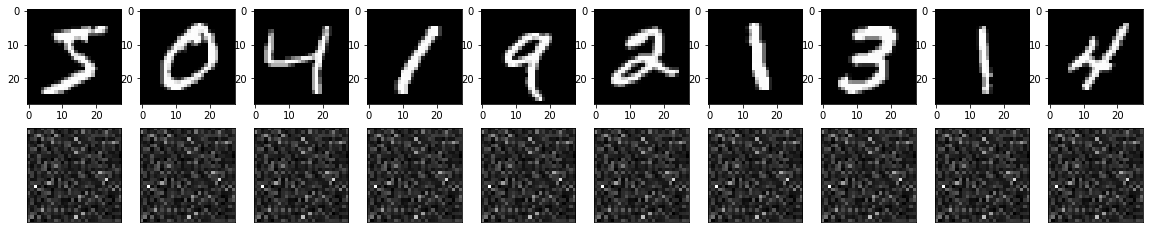

In [34]:
# we will encode just 10 samples
encoded_imgs = encoder_sae.predict(x_train[:10, :])

plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()